# 1. 데이터 전처리
## 1-1. 데이터 조사
피마 인디언 당뇨병 여부에 대한 데이터를 분석한다.
* sample: 768
* feature: 8
* class: 1(당뇨병 여부)

feature는 다음과 같다.

| num | feature | detail | 
| --- | --- | --- |
| 1 | pregnant | 과거 임신 횟수 |
| 2 | plasma | 포도당 부하 검사 2시간 후 공복 혈당 농도(mm Hg) |
| 3 | pressure | 확장기 혈압(mm Hg) |
| 4 | thickness | 삼두근 피부 주름 두께(mm) |
| 5 | insulin | 혈청 인슐린(2-hour, mu U/ml) |
| 6 | BMI | 체질량 지수(BMI, weight in kg/(height in m)^2) |
| 7 | pedigree | 당뇨병 가족력 |
| 8 | age | 나이
| class |  |당뇨(1), 당뇨 아님(0)

csv: comma separated values file의 약자로, 콤마(,)로 구분된 데이터들의 모음
* 헤더(header): 데이터를 설명하는 첫 번째 줄
* 헤더가 없으면 names()를 이용해서 각 feature의 키워드를 지정해 준다.

In [2]:
import pandas as pd

df = pd.read_csv('../../dataset/pima-indians-diabetes.csv',names=["pregnant","plasma","pressure","thickness","insulin","BMI","predigree","age",
                                                                "class"])
print(df.head(5))

   pregnant  plasma  pressure  thickness  insulin   BMI  predigree  age  class
0         6     148        72         35        0  33.6      0.627   50      1
1         1      85        66         29        0  26.6      0.351   31      0
2         8     183        64          0        0  23.3      0.672   32      1
3         1      89        66         23       94  28.1      0.167   21      0
4         0     137        40         35      168  43.1      2.288   33      1


In [13]:
print(df.info()) # 데이터에 대해 간략한 정보 볼 수 있음
#print(df.describe()) # feature 별 샘플 수, 평균, 표준편차, 최솟값, 백분위, 최솟값 등 알 수 있음
print(df[['pregnant','class']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pregnant   768 non-null    int64  
 1   plasma     768 non-null    int64  
 2   pressure   768 non-null    int64  
 3   thickness  768 non-null    int64  
 4   insulin    768 non-null    int64  
 5   BMI        768 non-null    float64
 6   predigree  768 non-null    float64
 7   age        768 non-null    int64  
 8   class      768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
     pregnant  class
0           6      1
1           1      0
2           8      1
3           1      0
4           0      1
..        ...    ...
763        10      0
764         2      0
765         5      0
766         1      1
767         1      0

[768 rows x 2 columns]


## 1-2. 데이터 가공
* groupby(): pregnant 정보를 기준으로 하는 새 그룹 만들음
* as_index=False: pregnant 정보 옆에 새로운 인덱스 만들음
* sort_values(): pregnant 컬럼을 오름차순(ascending)으로 정리

In [20]:
# 임신 횟수당 당뇨병 발병 확률
print(df[['pregnant','class']].groupby(['pregnant'],as_index=False).mean().sort_values(by='pregnant',ascending=True))

    pregnant     class
0          0  0.342342
1          1  0.214815
2          2  0.184466
3          3  0.360000
4          4  0.338235
5          5  0.368421
6          6  0.320000
7          7  0.555556
8          8  0.578947
9          9  0.642857
10        10  0.416667
11        11  0.636364
12        12  0.444444
13        13  0.500000
14        14  1.000000
15        15  1.000000
16        17  1.000000


## 1-3. 데이터 시각화
matplotlib 라이브러리
* figure(): 그래프 크기 결정

seaborn 라이브러리
* heatmap(): 각 항목 간의 상관관계 나타내 준다. 두 항목씩 짝을 지은 뒤 각각 어떤 패턴으로 변화하는지 관찰하는 함수다. 두 항목이 다른 패턴으로 변화하고 있으면 0을, 비슷한 패턴으로 변할수록 1에 가까운 값을 출력한다.




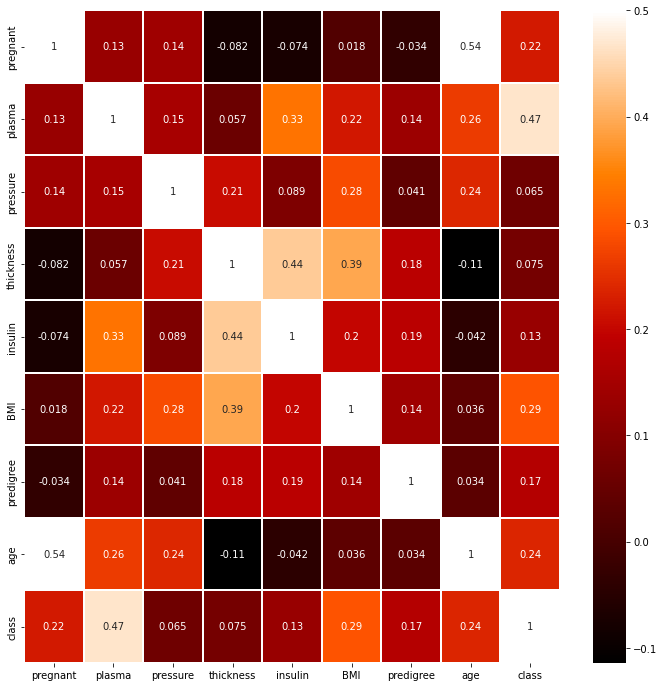

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,12)) # 그래프 크기 결정
sns.heatmap(df.corr(),linewidths=0.1,vmax=0.5, cmap=plt.cm.gist_heat,linecolor='white',annot=True)

plt.show()

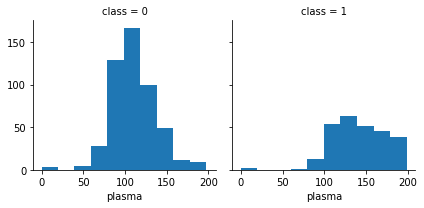

In [24]:
# plasma와 class 항목만 떼어서 두 항목 간의 관계 그래프로 나타내기
grid = sns.FacetGrid(df, col='class')
grid.map(plt.hist, 'plasma', bins=10)
plt.show()
# -> 당뇨병 환자(class = 1)의 경우 plasma 수치가 150 넘는 경우가 많다.

# 2. 예측 실행

## 2-1. 모델 설정
* 입력층: 입력 값 개수 8개
* 은닉층1: 노드 12개, relu
* 은닉층2: 노드 8개, relu
* 출력층: 출력 값 1개, sigmoid


* cost function: binary_crossentropy <- 이항 분류(binary classification) 문제이므로
* optimizer: adam
* epochs: 200 <- 전체 샘플이 200번 반복해서 입력될 때까지 실험 반복
* batch_size: 10 <- 한 번에 입력되는 입력 값 10개

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import tensorflow as tf

# seed 값 생성 -> 컴퓨터에 내장된 랜덤 테이블 중 하나 불러내는 것. seed 값 같으면 같은 값 불러옴.
np.random.seed(3)
tf.random.set_seed(3)
### 넘파이 라이브러리 사용하면서 텐서플로 기반으로 딥러닝 구현할 때는 두 seed 값 모두 설정해야 함.

# 데이터 로드
dataset = np.loadtxt("../../dataset/pima-indians-diabetes.csv",delimiter=",")
X = dataset[:,0:8]
Y = dataset[:,8]


# 모델의 설정
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# 모델 실행
model.fit(X,Y,epochs=200,batch_size=10)

# 결과 출력
print("\n Accuracy: %.4f" %(model.evaluate(X, Y)[1]))

Train on 768 samples
Epoch 1/200
768/768 [==============================] - 0s 501us/sample - loss: 11.4155 - accuracy: 0.6198
Epoch 2/200
768/768 [==============================] - 0s 74us/sample - loss: 6.4242 - accuracy: 0.6159
Epoch 3/200
768/768 [==============================] - 0s 77us/sample - loss: 3.6949 - accuracy: 0.5221
Epoch 4/200
768/768 [==============================] - 0s 79us/sample - loss: 2.2150 - accuracy: 0.5169
Epoch 5/200
768/768 [==============================] - 0s 76us/sample - loss: 1.3725 - accuracy: 0.5182
Epoch 6/200
768/768 [==============================] - 0s 82us/sample - loss: 0.9083 - accuracy: 0.5586
Epoch 7/200
768/768 [==============================] - 0s 82us/sample - loss: 0.7783 - accuracy: 0.5547
Epoch 8/200
768/768 [==============================] - 0s 78us/sample - loss: 0.7476 - accuracy: 0.6172
Epoch 9/200
768/768 [==============================] - 0s 79us/sample - loss: 0.7330 - accuracy: 0.6615s - loss: 0.7463 - accuracy: 0.67
Epoch 10

768/768 [==============================] - 0s 79us/sample - loss: 0.5329 - accuracy: 0.7135
Epoch 79/200
768/768 [==============================] - 0s 73us/sample - loss: 0.5319 - accuracy: 0.7148
Epoch 80/200
768/768 [==============================] - 0s 77us/sample - loss: 0.5388 - accuracy: 0.7109
Epoch 81/200
768/768 [==============================] - 0s 77us/sample - loss: 0.5295 - accuracy: 0.7148
Epoch 82/200
768/768 [==============================] - 0s 80us/sample - loss: 0.5244 - accuracy: 0.7201
Epoch 83/200
768/768 [==============================] - 0s 77us/sample - loss: 0.5314 - accuracy: 0.7096
Epoch 84/200
768/768 [==============================] - 0s 74us/sample - loss: 0.5288 - accuracy: 0.7253
Epoch 85/200
768/768 [==============================] - 0s 74us/sample - loss: 0.5330 - accuracy: 0.7148
Epoch 86/200
768/768 [==============================] - 0s 77us/sample - loss: 0.5315 - accuracy: 0.7109
Epoch 87/200
768/768 [==============================] - 0s 80us/samp

768/768 [==============================] - 0s 79us/sample - loss: 0.5159 - accuracy: 0.7201
Epoch 153/200
768/768 [==============================] - 0s 81us/sample - loss: 0.5196 - accuracy: 0.7266
Epoch 154/200
768/768 [==============================] - 0s 87us/sample - loss: 0.5053 - accuracy: 0.7214
Epoch 155/200
768/768 [==============================] - 0s 90us/sample - loss: 0.5055 - accuracy: 0.7266
Epoch 156/200
768/768 [==============================] - 0s 88us/sample - loss: 0.5043 - accuracy: 0.7174
Epoch 157/200
768/768 [==============================] - 0s 83us/sample - loss: 0.5131 - accuracy: 0.7266s - loss: 0.5136 - accuracy: 0.72
Epoch 158/200
768/768 [==============================] - 0s 87us/sample - loss: 0.5087 - accuracy: 0.7188
Epoch 159/200
768/768 [==============================] - 0s 85us/sample - loss: 0.5171 - accuracy: 0.7253
Epoch 160/200
768/768 [==============================] - 0s 85us/sample - loss: 0.5172 - accuracy: 0.7174
Epoch 161/200
768/768 [====


 Accuracy: 0.7253
